In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "RiceLeafs/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2684 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[2 1 3 3 1 1 1 1 1 0 3 2 1 3 2 1 1 2 1 2 3 1 1 3 1 1 2 2 3 2 2 1]


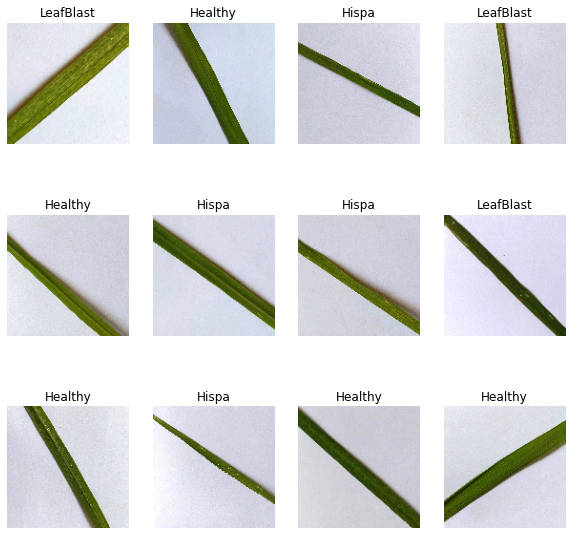

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
len(dataset)

84

In [15]:
train_size = 0.8
len(dataset)*train_size

67.2

In [16]:
train_ds = dataset.take(67)
len(train_ds)

67

In [17]:
test_ds = dataset.skip(67)
len(test_ds)

17

In [18]:
val_size=0.1
len(dataset)*val_size

8.4

In [19]:
val_ds = test_ds.take(8)
len(val_ds)

8

In [20]:
test_ds = test_ds.skip(8)
len(test_ds)

9

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

67

In [24]:
len(val_ds)

8

In [25]:
len(test_ds)

9

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
import tensorflow_hub as hub
model_handle = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

feature_extractor = hub.KerasLayer(model_handle,
                                   trainable=True)

num_class = len(class_names)

model_mobileNetV2 = tf.keras.Sequential(
    [
        normalization_layer,
        feature_extractor,
        tf.keras.layers.Dense(num_class, activation="softmax")
    ]
)

model_mobileNetV2.build([None, 128, 128, 3])
model_mobileNetV2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model_mobileNetV2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 4)                 4008      
                                                                 
Total params: 1696497 (6.47 MB)
Trainable params: 1682417 (6.42 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


In [29]:
# Early stopping when the score is over 99%
class myEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get("accuracy") >= 0.99):
            print("\nReached 99% accuracy. So, cancelled!")
            self.model.stop_training = True

In [30]:
save_dir = "/"
model_save_path = save_dir + "rice_disease_detector" + ".h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_path,
                                                     save_best_only=True,
                                                     verbose=1)
model_early_stop = myEarlyStopping()

history = model_mobileNetV2.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    validation_data=val_ds,
                    verbose=1,
                    epochs=15,
                        callbacks=[model_checkpoint, model_early_stop])

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 2.2153 - accuracy: 0.4813
Epoch 1: val_loss improved from inf to 1.85658, saving model to /rice_disease_detector.h5


C:\Users\Pradeeshwar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 137s 1s/step - loss: 2.2153 - accuracy: 0.4813 - val_loss: 1.8566 - val_accuracy: 0.5000
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.0883 - accuracy: 0.6112
Epoch 2: val_loss improved from 1.85658 to 1.45090, saving model to /rice_disease_detector.h5
67/67 [==============================] - 39s 578ms/step - loss: 1.0883 - accuracy: 0.6112 - val_loss: 1.4509 - val_accuracy: 0.4688
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 0.8720 - accuracy: 0.6799
Epoch 3: val_loss improved from 1.45090 to 1.35573, saving model to /rice_disease_detector.h5
67/67 [==============================] - 39s 575ms/step - loss: 0.8720 - accuracy: 0.6799 - val_loss: 1.3557 - val_accuracy: 0.5859
Epoch 4/15
67/67 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.7575
Epoch 4: val_loss improved from 1.35573 to 1.23945, saving model to /rice_disease_detector.h5
67/67 [==============================] - 4

In [31]:
scores = model_mobileNetV2.evaluate(test_ds)

9/9 [==============================] - 43s 102ms/step - loss: 0.9941 - accuracy: 0.7812


In [32]:
history

In [33]:
len(history.history['loss'])

15

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

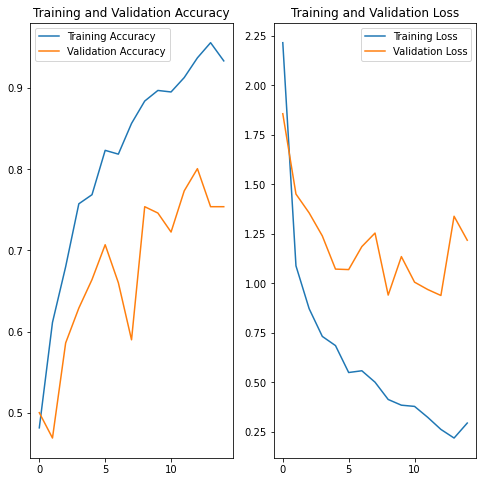

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(15), acc, label='Training Accuracy')
plt.plot(range(15), val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()